In [ ]:

import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

2025-05-09 20:16:26.307827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 20:16:26.316035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746839786.326178  337363 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746839786.329308  337363 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 20:16:26.339713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:

CONFIG = {
    "data_path": "data/emnist_balanced.npz",
    "mapping_file": "emnist-balanced-mapping.txt",
    "model_checkpoint": "savedModels/CNN-Model.keras",
    "batch_size": 64,
    "epochs": 20,
    "input_shape": (28, 28, 1),
    "num_classes": 47,
    "test_path": "path/to/your/image.png",  
}
NUM_CLASSES = 47


# CNN Training Notebook
This notebook trains the EMNIST Balanced model with a deeper architecture, no augmentation to ensure proper learning, and robust callbacks.

In [ ]:
import numpy as np
import random
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras import layers, models, optimizers, callbacks


seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

tf.config.experimental.enable_op_determinism()


In [ ]:

data = np.load('data/emnist_balanced.npz')
x = data['x']
y = data['y']


x = np.transpose(x, (0, 2, 1))
x = np.flip(x, axis=2)


x = x.astype('float32') / 255.0
x = x[..., np.newaxis]

print(f"Data shapes before split: {x.shape}, {y.shape}")


Data shapes before split: (112800, 28, 28, 1), (112800,)


In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, test_idx = next(sss.split(x, y))
x_train_full, x_test = x[train_idx], x[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, val_idx = next(sss2.split(x_train_full, y_train_full))
x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (91368, 28, 28, 1), Val: (10152, 28, 28, 1), Test: (11280, 28, 28, 1)


# Logistic Regression Baseline
This section trains a simple multinomial Logistic Regression model to serve as a lightweight, interpretable baseline.

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


x_train_lr = x_train.reshape(-1, 28*28)
x_val_lr   = x_val.reshape(-1, 28*28)
x_test_lr  = x_test.reshape(-1, 28*28)


lr = LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=1000,
        n_jobs=-1,
        verbose=1,
        random_state=seed)
lr.fit(x_train_lr, y_train)


y_val_pred = lr.predict(x_val_lr)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))


y_test_pred = lr.predict(x_test_lr)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))


/home/karan/miniconda3/envs/web-backend/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 20 epochs took 208 seconds
Validation accuracy: 0.4874901497241923
Test accuracy: 0.4767730496453901
              precision    recall  f1-score   support

           0      0.349     0.458     0.396       240
           1      0.175     0.600     0.271       240
           2      0.686     0.438     0.534       240
           3      0.438     0.858     0.580       240
           4      0.596     0.388     0.470       240
           5      0.833     0.229     0.359       240
           6      0.614     0.629     0.621       240
           7      0.547     0.846     0.664       240
           8      0.635     0.450     0.527       240
           9      0.376     0.683     0.485       240
          10      0.464     0.463     0.463       240
          11      0.620     0.429     0.507       240
          12      0.564     0.554     0.559       240
          13      0.714     0.312     0.435       240
          14      0.659     0.379     0.481       240
          15    

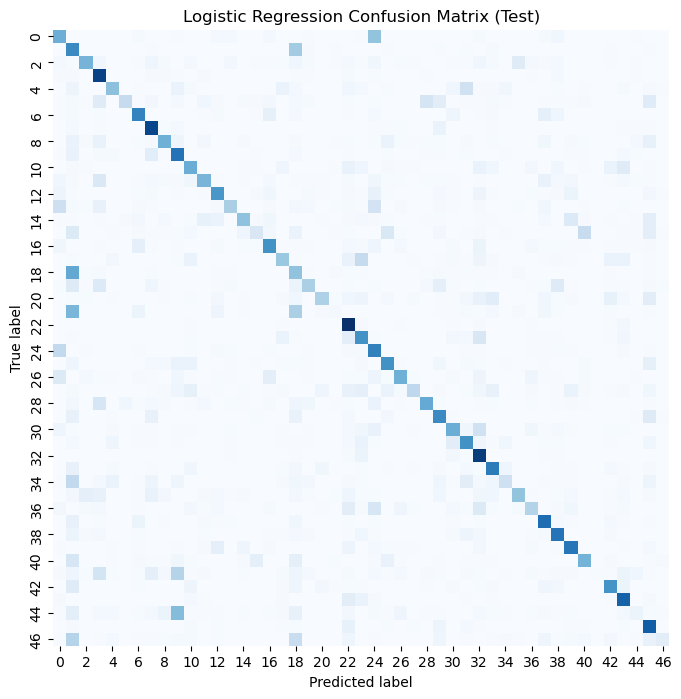

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap="Blues", square=True, cbar=False)
plt.title("Logistic Regression Confusion Matrix (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [ ]:

import joblib
from pathlib import Path

model_dir = Path("SavedModels")
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(lr, model_dir / "LogReg-Model-v2.joblib")
print(f"Model saved to {model_dir / 'LogReg-Model-v2.joblib'}")


Model saved to SavedModels/LogReg-Model-v2.joblib
